In [3]:
# import required libraries
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import string

In [4]:
# download punctuation and stopwords from nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nigel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nigel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nigel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nigel\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Transform the data

In [3]:
# load tweets_df and view
tweets_df = pd.read_csv("Resources/Tweets.csv")
tweets_df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [4]:
# get dataframe ready for processing

# make sure the tweets in column "text" are strings
tweets_df['text'] = tweets_df['text'].astype('str')

# delete the unneccessary columns
tweets_df = tweets_df.drop(columns=["textID", "selected_text"])

In [5]:
def process_tweets(tweet):
    # make the text all lowercase
    tweet = tweet.lower()
    
    # remove punctuation
    tweet = "".join(char for char in tweet if char not in string.punctuation)
    
    # tokenize the tweet for url clean
    tokenize_tweet_url = word_tokenize(tweet)
    
    # remove urls
    tokenize_tweet_url = " ".join([i for i in tokenize_tweet_url if 'http' not in i])
    
    # tokenize the tweet
    tokenize_tweets = word_tokenize(tokenize_tweet_url)
    
    # remove stopwords
    stopword = stopwords.words("english")
    tweet_wo_stop = [word for word in tokenize_tweets if word not in stopword]
    
    # lemmatization
    lemm = WordNetLemmatizer()
    lemmed = [lemm.lemmatize(word) for word in tweet_wo_stop]
    
    # put string together
    final_tweet = " ".join(lemmed)
    
    return final_tweet

In [6]:
# process tweets using above function
tweets_df['text'] = tweets_df['text'].apply(lambda x: process_tweets(x))
tweets_df = tweets_df.dropna()

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,neutral
1,sooo sad miss san diego,negative
2,bos bullying,negative
3,interview leave alone,negative
4,son couldnt put release already bought,negative


<AxesSubplot:ylabel='sentiment'>

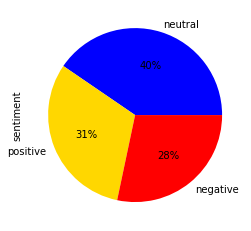

In [7]:
# visualize distribution
tweets_df.sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['blue', 'gold', 'red'])

In [8]:
# transform the sentiment column into numbers
dict_sentiment = {'positive': 1, 'neutral': 0, 'negative': -1}
tweets_df['sentiment'] = tweets_df['sentiment'].apply(lambda x: dict_sentiment.get(x))

# view updated dataframe
tweets_df.head()

,text,sentiment
0,id responded going,0
1,sooo sad miss san diego,-1
2,bos bullying,-1
3,interview leave alone,-1
4,son couldnt put release already bought,-1


In [9]:
# create a separate data frame without neutral tweets
tweets_no_neut = tweets_df[tweets_df["sentiment"] != 0]

In [10]:
# Create the X and y data 
def create_train_test_data (tweets_df, train_size):
    
    # assign X and y to the input and target columns
    X = tweets_df['text']
    y = tweets_df['sentiment']

    # split the data into testing data and training data
    if train_size == 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

    # transform the data into tfidf vectors
    # fit the tfidf vectorizer on the training data to avoid bias
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)
    
    return X_train_tfidf, X_test_tfidf, y_train, y_test

In [11]:
# create the model
def create_model(tweets_df, attempt_num, model, train_size):
    # Get the train and test data
    
    X_train_tfidf, X_test_tfidf, y_train, y_test = create_train_test_data (tweets_df, train_size)

    # create a logistic regression model and fit it to the training data
    
    model.fit(X_train_tfidf, y_train)
    evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num)

In [12]:
# evaluate the model
def evaluate(model, X_train_tfidf, y_train, X_test_tfidf, y_test, attempt_num):
    
    # look at the scores for the testing and training data
    print(f"Attempt {attempt_num} ----------------------------------------")
    print(f"Training Data Score: {model.score(X_train_tfidf, y_train)}")
    print(f"Testing Data Score: {model.score(X_test_tfidf, y_test)} \n")

    # find metrics for testing data
    print(confusion_matrix(y_test.values, model.predict(X_test_tfidf)))
    print(classification_report(y_test.values, model.predict(X_test_tfidf)))

## Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
create_model(tweets_df, 1, model, 0)
create_model(tweets_no_neut, 2, model, 0)

Attempt 1 ----------------------------------------
Training Data Score: 0.8185832120329937
Testing Data Score: 0.6819967981370979 

[[1144  716  103]
 [ 371 2073  323]
 [  76  596 1469]]
              precision    recall  f1-score   support

          -1       0.72      0.58      0.64      1963
           0       0.61      0.75      0.67      2767
           1       0.78      0.69      0.73      2141

    accuracy                           0.68      6871
   macro avg       0.70      0.67      0.68      6871
weighted avg       0.69      0.68      0.68      6871

Attempt 2 ----------------------------------------
Training Data Score: 0.9286179921773142
Testing Data Score: 0.8692251283304816 

[[1695  254]
 [ 281 1861]]
              precision    recall  f1-score   support

          -1       0.86      0.87      0.86      1949
           1       0.88      0.87      0.87      2142

    accuracy                           0.87      4091
   macro avg       0.87      0.87      0.87      4091
w

C:\Users\apfle\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

twitter_classi = RandomForestClassifier(n_estimators=300, random_state=0)
create_model(tweets_df, 1, twitter_classi, train_size=.8)
create_model(tweets_no_neut, 2, twitter_classi, train_size=.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.9977256186317321
Testing Data Score: 0.6971075131890122 

[[ 882  508  109]
 [ 252 1644  346]
 [  77  373 1306]]
              precision    recall  f1-score   support

          -1       0.73      0.59      0.65      1499
           0       0.65      0.73      0.69      2242
           1       0.74      0.74      0.74      1756

    accuracy                           0.70      5497
   macro avg       0.71      0.69      0.69      5497
weighted avg       0.70      0.70      0.70      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9994652406417113
Testing Data Score: 0.8670944087992667 

[[1355  193]
 [ 242 1483]]
              precision    recall  f1-score   support

          -1       0.85      0.88      0.86      1548
           1       0.88      0.86      0.87      1725

    accuracy                           0.87      3273
   macro avg       0.87      0.87      0.87      3273
w

## Extra Trees Classifier

In [15]:
from sklearn.ensemble import ExtraTreesClassifier

twitter_ex = ExtraTreesClassifier(random_state=1)
create_model(tweets_df, 1, twitter_ex, train_size=.8)
create_model(tweets_no_neut, 2, twitter_ex, train_size=.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.9978165938864629
Testing Data Score: 0.7100236492632345 

[[ 996  484  107]
 [ 297 1627  314]
 [  78  314 1280]]
              precision    recall  f1-score   support

          -1       0.73      0.63      0.67      1587
           0       0.67      0.73      0.70      2238
           1       0.75      0.77      0.76      1672

    accuracy                           0.71      5497
   macro avg       0.72      0.71      0.71      5497
weighted avg       0.71      0.71      0.71      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.9994652406417113
Testing Data Score: 0.8533455545371219 

[[1283  221]
 [ 259 1510]]
              precision    recall  f1-score   support

          -1       0.83      0.85      0.84      1504
           1       0.87      0.85      0.86      1769

    accuracy                           0.85      3273
   macro avg       0.85      0.85      0.85      3273
w

## Ada Boost Classifier

In [16]:
from sklearn.ensemble import AdaBoostClassifier
twitter_ada = AdaBoostClassifier(random_state=1)
create_model(tweets_df, 1, twitter_ada, train_size=.8)
create_model(tweets_no_neut, 2, twitter_ada, train_size=.8)

Attempt 1 ----------------------------------------
Training Data Score: 0.6556131732168851
Testing Data Score: 0.6450791340731308 

[[ 598  839  109]
 [ 148 1835  256]
 [  40  559 1113]]
              precision    recall  f1-score   support

          -1       0.76      0.39      0.51      1546
           0       0.57      0.82      0.67      2239
           1       0.75      0.65      0.70      1712

    accuracy                           0.65      5497
   macro avg       0.69      0.62      0.63      5497
weighted avg       0.68      0.65      0.63      5497

Attempt 2 ----------------------------------------
Training Data Score: 0.807257448433919
Testing Data Score: 0.7925450656889703 

[[1422   99]
 [ 580 1172]]
              precision    recall  f1-score   support

          -1       0.71      0.93      0.81      1521
           1       0.92      0.67      0.78      1752

    accuracy                           0.79      3273
   macro avg       0.82      0.80      0.79      3273
we

# Naive Bayes

In [ ]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train_tfidf, y_train).predict(X_test_tfidf)

from sklearn import metrics
accuracy_score = metrics.accuracy_score(y_pred, y_test)

print(accuracy_score)